## Image classification using Food-101 dataset

### Task description
1. Grab the dataset from https://huggingface.co/datasets/food101
2. Implement a convolutional neural network for multiclass image classification.
3. Use https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html or `dl_lab5` for inspiration.

In [2]:
import torch
import pandas as pd
import numpy as np
import random 
import os
import matplotlib.pyplot as plt
from PIL import Image
import io
import torchvision.transforms as transforms

In [3]:
train_data = pd.read_parquet("train-00000-of-00008.parquet")
train_data.shape

(9469, 3)

In [4]:
val_data = pd.read_parquet("validation-00000-of-00003.parquet")
val_data.shape

(8417, 3)

In [5]:
val_data.head()

,label,image.bytes,image.path
0,6,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,1827892.jpg
1,6,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,2802124.jpg
2,6,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,2192983.jpg
3,6,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,1062952.jpg
4,6,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...,3157161.jpg


In [6]:
val_data.columns

Index(['label', 'image.bytes', 'image.path'], dtype='object')

In [7]:
val_data.label.unique()

array([ 6, 79, 81, 53, 10, 20, 77, 48, 86, 84, 76, 34, 51, 21, 64,  0, 43,
       44, 73, 57, 14,  5, 46, 55, 93, 98, 38, 11, 99, 72, 22, 59, 70, 16])

In [8]:
train_data.label.unique()

array([ 6, 79, 81, 53, 10, 20, 77, 48, 86, 84, 76, 34, 51])

In [9]:
len(train_data.label.unique())

13

In [10]:
val_data = val_data[val_data.label.isin(train_data.label.unique())]

In [11]:
val_data.shape

(3250, 3)

In [12]:
classes = dict(enumerate([ 6, 79, 81, 53, 10, 20, 77, 48, 86, 84, 76, 34, 51]))

In [13]:
classes_rev = {i: ii for ii, i in classes.items()}

In [14]:
classes_rev

{6: 0,
 79: 1,
 81: 2,
 53: 3,
 10: 4,
 20: 5,
 77: 6,
 48: 7,
 86: 8,
 84: 9,
 76: 10,
 34: 11,
 51: 12}

In [15]:
train_data.label = train_data.label.map(classes_rev)
val_data.label = val_data.label.map(classes_rev)

In [16]:
train_data.label[1]

0

In [23]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()])

In [24]:
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y, trans):
        self.x = x
        self.y = y
        self.trans = trans
    
    
    def __len__(self):
        return self.y.shape[0]
    
    
    def __getitem__(self, index):
        image = Image.open(io.BytesIO(self.x[index]))
        
        return self.trans(image), self.y[index]

In [25]:
val_dataset = Custom_Dataset(val_data["image.bytes"], val_data.label, transform)
train_dataset = Custom_Dataset(train_data["image.bytes"], train_data.label, transform)

In [26]:
val_data_load = torch.utils.data.DataLoader(val_dataset, batch_size=32)
train_data_load = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [27]:
next(iter(train_data_load))[0].shape

torch.Size([32, 3, 64, 64])

In [28]:
len(train_data_load)

296

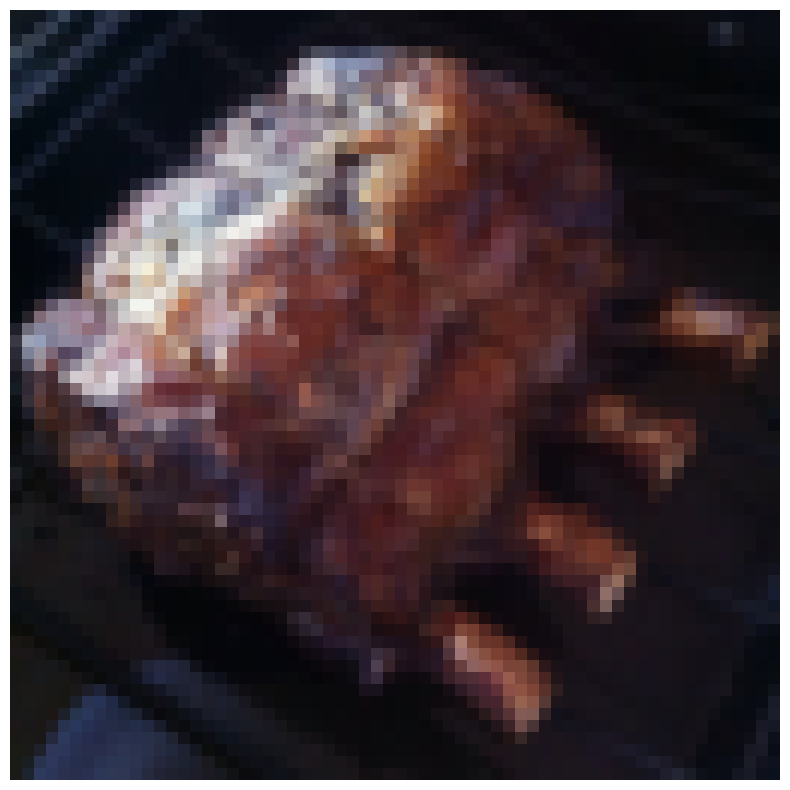

In [29]:
index = random.randint(0, len(train_dataset) - 1)

image = train_dataset[index][0].permute(1, 2, 0).detach().cpu().numpy()

plt.figure(figsize=(10, 10))

plt.imshow(image)
plt.axis(False)
plt.show()

In [43]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 64, 3, 1),
    torch.nn.LazyBatchNorm2d(),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, 32, 3, 1),
    torch.nn.LazyBatchNorm2d(),
    torch.nn.ReLU(),
    torch.nn.Conv2d(32, 16, 3, 1),
    torch.nn.LazyBatchNorm2d(),
    torch.nn.ReLU(),
    torch.nn.Conv2d(16, 8, 3, 1),
    torch.nn.LazyBatchNorm2d(),
    torch.nn.ReLU(),
    torch.nn.Flatten(),
    torch.nn.LazyLinear(13),
    torch.nn.Softmax(dim=-1)
)

/home/user/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [44]:
model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (7): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (10): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): LazyLinear(in_features=0, out_features=13, bias=True)
  (14): Softmax(dim=-1)
)

In [45]:
noice = torch.randn(32, 3, 64, 64)

In [46]:
model(noice).shape

torch.Size([32, 13])

In [47]:
loss_f = torch.nn.CrossEntropyLoss()
opti = torch.optim.Adam(model.parameters())

In [48]:
epochs = 10

history_train = []
history_val = []

for epoch in range(1, epochs + 1):
    total_train_loss = 0

    model.train()

    for batch_i, (x, y) in enumerate(iter(train_data_load)):
        x, y = x.to(torch.float32), y.to(torch.int64)

        pred = model(x)

        loss = loss_f(pred, y)

        opti.zero_grad()
        loss.backward()
        opti.step()

        total_train_loss += loss.item()

    total_train_loss /= len(train_data_load)

    total_val_loss = 0

    model.eval()

    for x, y in iter(val_data_load):
        with torch.inference_mode():
            pred = model(x)
            loss = loss_f(pred, y)

        total_val_loss += loss.item()

    total_val_loss /= len(val_data_load)

    history_train.append(total_train_loss)
    history_val.append(total_val_loss)

    print(f"[Epoch: {epoch}/{epochs}; train_loss: {total_train_loss}; val_loss: {total_val_loss}]")

[Epoch: 1/10; train_loss: 2.576460195554269; val_loss: 2.6024367493741654]
[Epoch: 2/10; train_loss: 2.563145954061199; val_loss: 2.5762458677385367]
[Epoch: 3/10; train_loss: 2.5794353920060233; val_loss: 2.5787284701478246]
[Epoch: 4/10; train_loss: 2.573542076188165; val_loss: 2.567960931974299]
[Epoch: 5/10; train_loss: 2.5702669974919914; val_loss: 2.5741815239775416]
[Epoch: 6/10; train_loss: 2.570085028538833; val_loss: 2.563296508555319]
[Epoch: 7/10; train_loss: 2.5699123538829185; val_loss: 2.5674626324691023]
[Epoch: 8/10; train_loss: 2.567897742664492; val_loss: 2.567424810400196]
[Epoch: 9/10; train_loss: 2.566127872950322; val_loss: 2.565334642634672]
[Epoch: 10/10; train_loss: 2.5681263554740594; val_loss: 2.5613811156328987]


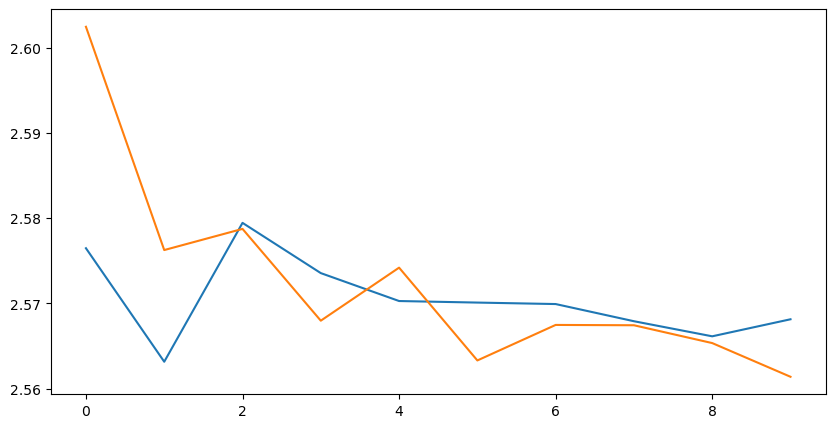

In [49]:
plt.figure(figsize=(10, 5))

plt.plot(history_train)
plt.plot(history_val)

plt.show()